<h1>Process & ML TIME</h1>

Process info from Monmouth University 2020 national poll

In [1]:
import os 
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split

from utils import * 


from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold

from sklearn.pipeline import Pipeline



In [2]:
# read in propensity scores
propensity = pd.read_csv("../data/new_prop_scores_all.csv")



<h2>Rename Columns</h2>

In [3]:
def recodeCols(df):

    cols = df.columns
    # vote choice
    if '12_2' not in cols:
        # for march 2020 data
        df['vote_choice_recoded'] = df.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
        df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))
    else:
        # for june 2020 data
        df['vote_choice'] = df.apply(lambda s: np.where(pd.isnull(s['12_1']), s['12_2'], s['12_1']), axis = 1)
      
        df['vote_choice_recoded'] = df.apply(lambda s: np.where(s['vote_choice'] in [6.0, 8.0, 9.0, 7.0], s['vote_choice_undecided'], s['vote_choice']), axis = 1)
        df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s in [3.0, 4.0, 9.0], 3.0, s))
    # party recode
    df['party_recoded'] = df.apply(lambda s: np.where(s['party'] in [4.0, 9.0], s['party_unaffiliated'], s['party']), axis = 1)
    df['party_recoded'] = df['party_recoded'].apply(lambda s: np.where(s in [3.0, 9.0], 3.0, s))

    # age recode
    df['age_recoded'] = df.apply(lambda s: np.where(not pd.isnull(s['age_bin']), s['age_bin'], s['age']), axis = 1)

    df['age_recoded'] = df['age_recoded'].apply(lambda s: np.where(s >= 18 and s <= 34 and not pd.isnull(s), 1.0, np.where(s >= 35 and s <= 54, 2.0, 3.0)))   

    # approval ratings 
    df['approve_trump'] = df['approve_trump'] == 1
    df['approve_biden'] = df['approve_biden'] == 1 

    # race, overwrite if hispanic/latino
    df['latino'] = df['latino'] == 1

    def recode_race(s):
        if s['latino'] == 1 or s['race'] == 4: 
            return 4
        elif s['race'] != 5 and s['race'] != 9:
            return s['race']
        else:
            return 9
    df['race_recoded'] = df.apply(recode_race, axis = 1)

    # gender => male = True, female = False
    df['male'] = df['gender'] == 1

    # registered to vote

    df['registered_vote'] = df['registered_vote'] == 1


    # True if they think Trump is focused on important issues, False otherwise
    if 'focused_imp_issues' in cols:
        df['focused_imp_issues'] = df['focused_imp_issues'] == 1

    # combine some of the similar household concern categories 
    if 'top_household_concern' in cols:
        df['top_household_concern'] = df['top_household_concern'].apply(lambda s: np.where(s in [6.0, 7.0], 6.0, s))
        df['top_household_concern'] = df['top_household_concern'].apply(lambda s: np.where(s in [10.0, 11.0], 10.0, s))

    # turn into 1 = no college, 3 = college
    def recode_education(s):
        if s <= 3:
            return 1
        else:
            return 3
    df['education_recoded'] = df['education'].apply(recode_education)
    # combine into liberal, conservative, moderate, or other
    def recode_political_leaning(s):
        if s <= 2:
            return 1
        elif s == 4 or s == 9:
            return 2
        elif s == 3:
            return 3
        else:
            return 4
    df['political_leaning'] = df['political_leaning'].apply(recode_political_leaning)

    # Do you feel optimistic or pessimistic about the 2020 presidential election? 1 or 2 = optimistic of some sort, else pessimistic of some sort
    df['optimistic'] = df['optimistic'] <= 2

    # confidence in trump stamina to be president, under 2 is confident, over 2 is not confident
    if 'trump_stamina' in cols:
        df['trump_stamina'] = df['trump_stamina'] <= 2
    # confidence in biden stamina to be president, under 2 is confident, over 2 is not confident
    if 'biden_stamina' in cols:
        df['biden_stamina'] = df['biden_stamina'] <= 2
    ### https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf
    def recode_region(s):
        new_england = [9.0, 23.0, 25.0, 33.0, 44.0, 50.0, 34.0, 36.0, 42.0]
        midwest = [18.0, 17.0, 26.0, 39.0, 55.0, 19.0, 20.0, 27.0, 29.0, 31.0, 38.0, 46.0]
        south = [10.0, 11.0, 12.0, 13.0, 24.0, 37.0, 45.0, 51.0, 54.0, 1.0, 21.0, 28.0, 47.0, 5.0, 22.0, 40.0, 48.0]
        west = [4.0, 8.0, 16.0, 35.0, 30.0, 49.0, 32.0, 56.0, 2.0, 6.0, 15.0, 41.0, 53.0]
        
        if s in new_england:
            return 1
        elif s in midwest:
            return 2 
        elif s in south:
            return 3
        elif s in west:
            return 4
        
    df['region'] = df['state'].apply(recode_region)

    # merge propensities
    df['age_recoded'] = df['age_recoded'].astype(int)
    df_result = pd.merge(df, propensity, 
                        on=['male', 'race_recoded', 'education_recoded', 'age_recoded', 'STATEFIP'], 
                        how='left')

    # Renaming the merged column for clarity
    df['propensity'] = df_result['mrp_subgroup_estimate']
    df = df.dropna(subset = ['vote_choice_recoded'], how = 'all')

    return df

In [4]:
nat_2020 = pd.read_csv("../data/national_march_2020/MUP213_NATL_archive.tab", sep = "\t")
nat_2020 = nat_2020.rename(columns = {
        'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12B': 'vote_choice_undecided', 
        'Q13': 'approve_trump',
        'Q14': 'approve_biden',
        'Q15': 'optimistic',
        'Q16': 'elec_enthusiasm',
        'Q17': 'economic_situation',
        'Q19': 'focused_imp_issues',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})

nat_2020 = nat_2020.drop(columns = [c for c in nat_2020.columns if 'Q' in c])
nat_2020['STATEFIP'] = nat_2020['state']
nat_2020 = recodeCols(nat_2020)
third_party_mar = nat_2020[nat_2020['vote_choice_recoded'] == 3.0]

nat_2020_pre_dummies = nat_2020.copy()


In [5]:
nat_2020_june = pd.read_csv("../data/national_june_2020/MUP218_NATL_archive_full.tab", sep = "\t")
nat_2020_june = nat_2020_june.rename(columns = {
        # 'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q11': 'likely_to_vote', 
        'Q12': 'vote_choice', 
        'Q12_1': '12_1',
        'Q12_2': '12_2',
        'Q12B': 'vote_choice_undecided', 
        'Q15': 'approve_trump',
        'Q16': 'approve_biden',
        'Q19': 'optimistic',
        'Q21': 'elec_enthusiasm',
        'Q3': 'economic_situation',
        # 'Q19': 'focused_imp_issues',
        'Q17': 'trump_stamina',
        'Q18': 'biden_stamina',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})
nat_2020_june = nat_2020_june.drop(columns = [c for c in nat_2020_june.columns if 'Q' in c])
nat_2020_june['STATEFIP'] = nat_2020_june['state']
nat_2020_june = recodeCols(nat_2020_june)
nat_2020_june.drop(columns=['12_1', '12_2', 'vote_choice', 'vote_choice_undecided'], inplace = True)
third_party_june = nat_2020_june[nat_2020_june['vote_choice_recoded'] == 3.0]


In [7]:
nat_2020_aug = pd.read_csv("../data/national_aug_2020/MUP222_NATL_archive_full.tab", sep = "\t")
nat_2020_aug = nat_2020_aug.rename(columns = {
        'Q3': 'top_household_concern',
        'QD1': 'registered_vote',
        'Q13': 'likely_to_vote', 
        'Q14': 'vote_choice', 
  
        'Q14B': 'vote_choice_undecided', 
        'Q17': 'approve_trump',
        'Q18': 'approve_biden',
        'Q21': 'optimistic',
        'Q23': 'elec_enthusiasm',
        # 'Q3': 'economic_situation',
        # 'Q19': 'focused_imp_issues',
        # 'Q17': 'trump_stamina',
        # 'Q18': 'biden_stamina',
        'QD2': 'party',
        'QD2A': 'party_unaffiliated', 
        'QD3': 'political_leaning', 
        'QD4': 'education',
        'QD5': 'age', 
        'QD5A': 'age_bin', 
        'QD7': 'latino', 
        'QD8': 'race', 
        'QD10': 'gender', 
        'QD11': 'state'
})
nat_2020_aug = nat_2020_aug.drop(columns = [c for c in nat_2020_aug.columns if 'Q' in c])
nat_2020_aug['STATEFIP'] = nat_2020_aug['state']

nat_2020_aug = recodeCols(nat_2020_aug)

nat_2020_aug.drop(columns=['vote_choice', 'vote_choice_undecided'], inplace = True)

<h2>Add Dummy Variables</h2>

In [8]:
categoricals = ['registered_vote', 'region','economic_situation','likely_to_vote', 'education_recoded','elec_enthusiasm', 'political_leaning', 'race_recoded', 'party_recoded', 'age_recoded']
june_categoricals = ['registered_vote', 'region','economic_situation','likely_to_vote',  'education_recoded','elec_enthusiasm', 'political_leaning','race_recoded', 'party_recoded', 'age_recoded']
aug_categoricals = ['registered_vote', 'region','top_household_concern','likely_to_vote',  'education_recoded','elec_enthusiasm', 'political_leaning','race_recoded', 'party_recoded', 'age_recoded']

In [9]:
def dummyGrabber(df, cats):
    for category in cats:
        df[category] = df[category].astype('category')
    dummies = pd.get_dummies(df[cats])
    df = df[[c for c in df.columns if c not in cats]]
        
    df = pd.concat([df, dummies], axis = 1)
    
    return df

In [10]:
def checkVoteRecode(df):
    df = df[df['vote_choice_recoded'] != 3.0]
    # change trump to be 1 and biden to be 0
    # biden originally encoded as 2 and trump as 1. 
    # drop if vote choice recorded is null
    df = df.dropna(subset = ['vote_choice_recoded'])
    # vote choice recoded to int
    df['vote_choice_recoded'] = df['vote_choice_recoded'].astype(int)
    df['vote_choice_recoded'] = df['vote_choice_recoded'].apply(lambda s: np.where(s == 1, 1, 0))


    return df

In [11]:
nat_2020_june = checkVoteRecode(nat_2020_june)
nat_2020_aug = checkVoteRecode(nat_2020_aug)
nat_2020 = checkVoteRecode(nat_2020)

In [12]:
march_dummies = dummyGrabber(nat_2020, categoricals)
nat_2020_clean = march_dummies.drop(columns = ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education',])
nat_2020_clean
nat_2020_clean2= nat_2020_clean.drop(columns=['FINALWGT', 'vote_choice', 'vote_choice_undecided','state'])
# nat_2020_clean2= nat_2020_clean.drop(columns=[ 'vote_choice', 'vote_choice_undecided','state'])
nat_2020_clean2.columns

Index(['top_household_concern', 'approve_trump', 'approve_biden', 'optimistic',
       'focused_imp_issues', 'STATEFIP', 'vote_choice_recoded', 'male',
       'propensity', 'registered_vote_True', 'region_1.0', 'region_2.0',
       'region_3.0', 'region_4.0', 'economic_situation_1',
       'economic_situation_2', 'economic_situation_3', 'economic_situation_9',
       'likely_to_vote_1.0', 'likely_to_vote_2.0', 'likely_to_vote_3.0',
       'likely_to_vote_4.0', 'education_recoded_1', 'education_recoded_3',
       'elec_enthusiasm_1', 'elec_enthusiasm_2', 'elec_enthusiasm_3',
       'elec_enthusiasm_9', 'political_leaning_1', 'political_leaning_2',
       'political_leaning_3', 'political_leaning_4', 'race_recoded_1',
       'race_recoded_2', 'race_recoded_3', 'race_recoded_4', 'race_recoded_9',
       'party_recoded_1.0', 'party_recoded_2.0', 'party_recoded_3.0',
       'age_recoded_1', 'age_recoded_2', 'age_recoded_3'],
      dtype='object')

In [13]:
june_dummies = dummyGrabber(nat_2020_june, june_categoricals)
nat_2020_june_clean = june_dummies.drop(columns = ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education',])
nat_2020_june_clean
nat_2020_june_clean2 = nat_2020_june_clean.drop(columns=['FINALWGT', 'state'])


In [14]:
aug_dummies = dummyGrabber(nat_2020_aug, aug_categoricals)
nat_2020_aug_clean = aug_dummies.drop(columns = ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education',])
nat_2020_aug_clean
nat_2020_aug_clean2 = nat_2020_aug_clean.drop(columns=['FINALWGT', 'state'])


# MACHINE LEARNING SETUP

In [312]:
models = [
  
    ("Random Forest Classification", RandomForestClassifier(),{'n_estimators': [ 125, 150,200,225, 250, 350, 400], 'max_depth':[ 3, 4, 5, 6], 'min_samples_split': [3, 4, 5, 6],'max_features': ['sqrt', 'log2', 0.3], 'random_state': [13]}),

    ('Gradient Boosting Classification', GradientBoostingClassifier(), {'n_estimators': [100, 150,200, 300, 450], 'max_depth': [3, 5, 4, 6,7], 'learning_rate': [0.01,.05, 0.75, 0.1], 'max_features': ['sqrt', 'log2', 0.8], 'random_state': [13]}),

]

In [313]:
def modelFunc(X_train, y_train, X_test, y_test, data_dummies, models):
    best_f1 = 0
    for model in models:
    
        name = model[0]
        print(model[0])
        clf = model[1]
        params = model[2]

      
        grids =  GridSearchCV(clf, param_grid=params, scoring=['f1_weighted', 'neg_root_mean_squared_error'],cv=3, n_jobs=-1, refit='neg_root_mean_squared_error')
        grids.fit(X_train, y_train)
        y_preds = grids.best_estimator_.predict(X_test)
        if f1_score(y_test, y_preds, average='weighted') >= best_f1:
            new_model = grids.best_estimator_
            best_f1 = f1_score(y_test, y_preds, average='weighted')
    

        print(classification_report(y_test, y_preds))
        
     
        print('f1', f1_score(y_test, y_preds, average='weighted'))
    print('best model', new_model, 'model params', new_model.get_params())
    new_model.fit(X_train, y_train)


    features=X_train.columns
    importances = new_model.feature_importances_
    indices = np.argsort(importances)


    feat_importances = pd.Series(new_model.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(15).plot(kind='barh')

    y_preds = new_model.predict(X_test)
    y_preds_prob = new_model.predict_proba(X_test)
    y_preds_prob = [x[1] for x in y_preds_prob]
    X_test_copy = X_test.copy()
    X_test_copy['predicted_prob_vote'] = y_preds_prob
    X_test_copy['predicted_vote'] = y_preds
    X_test_copy['actual_vote'] = y_test
    X_test_copy_filtered = X_test_copy[['approve_trump', 'approve_biden', 'optimistic','male',  'race_recoded_1', 'race_recoded_2', 'race_recoded_3', 'race_recoded_4',
       'race_recoded_9', 'party_recoded_1.0',
       'party_recoded_2.0', 'age_recoded_1', 'age_recoded_2', 'age_recoded_3', 'predicted_vote','actual_vote', 'education_recoded_3', 'education_recoded_1']]

    filtered_nat_df = data_dummies.loc[X_test_copy_filtered.index].drop(columns= ['RESPID', 'PHTYPE', 'age', 'age_bin', 'party', 'party_unaffiliated', 'gender', 'latino', 'race', 'education', 'vote_choice_recoded', 'state'])
    filtered_nat_df['predicted_prob_vote'] = X_test_copy['predicted_prob_vote']
    filtered_nat_df['predicted_vote'] = X_test_copy['predicted_vote']
    filtered_nat_df['actual_vote'] = X_test_copy['actual_vote']
    
 

    # probability version
    df_final_pred_prob = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_prob_vote'].mean()

    # vote choice version

    df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)

    return df_final_pred_prob, df_final_pred, new_model

Random Forest Classification


              precision    recall  f1-score   support

           0       0.91      0.95      0.93       224
           1       0.94      0.90      0.92       204

    accuracy                           0.93       428
   macro avg       0.93      0.93      0.93       428
weighted avg       0.93      0.93      0.93       428

f1 0.9274664195817465
Gradient Boosting Classification
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       224
           1       0.94      0.88      0.91       204

    accuracy                           0.91       428
   macro avg       0.92      0.91      0.91       428
weighted avg       0.91      0.91      0.91       428

f1 0.9133477364824204
best model RandomForestClassifier(max_depth=5, max_features='log2', min_samples_split=4,
                       n_estimators=125, random_state=13) model params {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_feature

<Axes: >

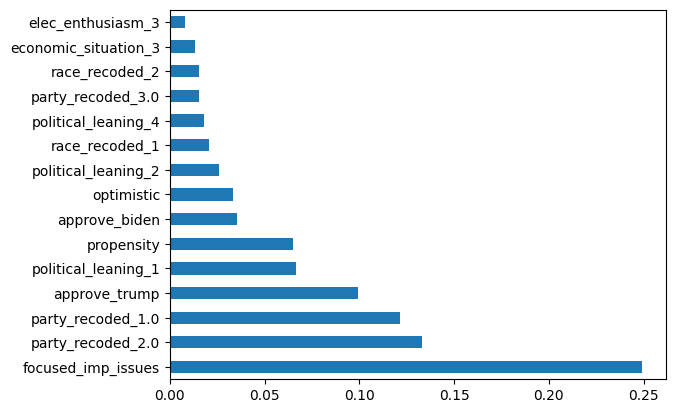

In [464]:
nat_2020_clean2 = nat_2020_clean2.dropna()
X = nat_2020_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP', 'top_household_concern'])
y = nat_2020_clean2['vote_choice_recoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6, random_state = 13)
mar_pred_probs, mar_pred, new_model_mar = modelFunc(X_train, y_train, X_test, y_test, nat_2020_pre_dummies, models)
features=X_train.columns
importances = new_model_mar.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(new_model_mar.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [309]:
nat_2020_clean2 = nat_2020_clean2.dropna()
X = nat_2020_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP', 'top_household_concern'])
y = nat_2020_clean2['vote_choice_recoded']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6, random_state = 13)
new_model_mar
y_preds = new_model_mar.predict(X_test)
y_preds = new_model_mar.predict_proba(X_test)
# y_preds = [x[1] for x in y_preds]

In [310]:
y_preds

array([[0.79911077, 0.20088923],
       [0.29364435, 0.70635565],
       [0.6562499 , 0.3437501 ],
       [0.41512278, 0.58487722],
       [0.38939789, 0.61060211],
       [0.20977042, 0.79022958],
       [0.79559361, 0.20440639],
       [0.29863749, 0.70136251],
       [0.76098771, 0.23901229],
       [0.21037241, 0.78962759],
       [0.20826166, 0.79173834],
       [0.74729852, 0.25270148],
       [0.47913031, 0.52086969],
       [0.26291961, 0.73708039],
       [0.59965158, 0.40034842],
       [0.81732893, 0.18267107],
       [0.32308101, 0.67691899],
       [0.21636831, 0.78363169],
       [0.3180489 , 0.6819511 ],
       [0.8012653 , 0.1987347 ],
       [0.82582956, 0.17417044],
       [0.20867647, 0.79132353],
       [0.28711995, 0.71288005],
       [0.77814417, 0.22185583],
       [0.56023266, 0.43976734],
       [0.82029016, 0.17970984],
       [0.76351042, 0.23648958],
       [0.79720802, 0.20279198],
       [0.77247582, 0.22752418],
       [0.78955748, 0.21044252],
       [0.

### Cleaned feature plots

<Axes: >

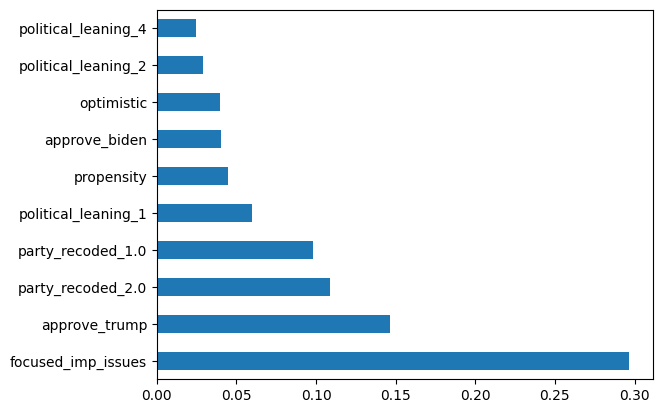

In [263]:
features=X_train.columns
importances = new_model_mar.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(new_model_mar.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

<Axes: title={'center': 'Machine Learning Model Feature Importances'}, xlabel='Feature Importances', ylabel='Poll Questions'>

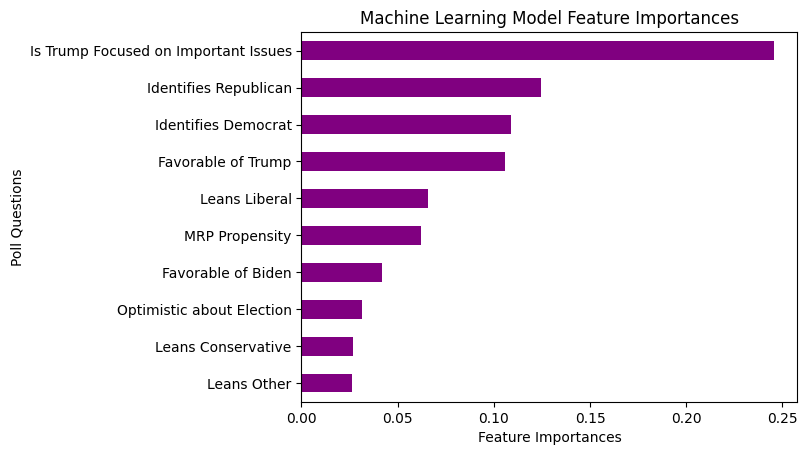

In [264]:
feat_importances.nlargest(10).to_dict()
# importances obtained from the 10 largest features importances
importances = {'Is Trump Focused on Important Issues': 0.24551637087202546,
 'Identifies Republican': 0.12466693943532543,
 'Identifies Democrat': 0.10894603472895334,
 'Favorable of Trump': 0.10586249291368698,
 'Leans Liberal': 0.0656888460601003,
 'MRP Propensity': 0.06190145440541663,
 'Favorable of Biden': 0.04195795725784075,
 'Optimistic about Election': 0.03136094290446979,
 'Leans Conservative': 0.02699039444792767,
 'Leans Other': 0.02642526434093232}
# make bar plot of importances
import matplotlib.pyplot as plt

# convert importances to a series
# sort importances to be in descending order
importances_s = pd.Series(importances.values(), importances.keys())
# sort importances
importances_s = importances_s.sort_values(ascending=True)

importances_s.plot(kind='barh', color='purple', title='Machine Learning Model Feature Importances', xlabel='Feature Importances', ylabel='Poll Questions')


In [265]:
importances_s

Leans Other                             0.026425
Leans Conservative                      0.026990
Optimistic about Election               0.031361
Favorable of Biden                      0.041958
MRP Propensity                          0.061901
Leans Liberal                           0.065689
Favorable of Trump                      0.105862
Identifies Democrat                     0.108946
Identifies Republican                   0.124667
Is Trump Focused on Important Issues    0.245516
dtype: float64

Random Forest Classification
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       246
           1       0.97      0.91      0.94       171

    accuracy                           0.95       417
   macro avg       0.96      0.95      0.95       417
weighted avg       0.95      0.95      0.95       417

f1 0.9517373114495418
Gradient Boosting Classification
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       246
           1       0.95      0.90      0.92       171

    accuracy                           0.94       417
   macro avg       0.94      0.93      0.94       417
weighted avg       0.94      0.94      0.94       417

f1 0.9397762903126278
best model RandomForestClassifier(max_depth=6, max_features=0.3, min_samples_split=3,
                       n_estimators=150, random_state=13) model params {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'm

/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_48809/170343472.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred_prob = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_prob_vote'].mean()
/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_48809/170343472.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)


<Axes: >

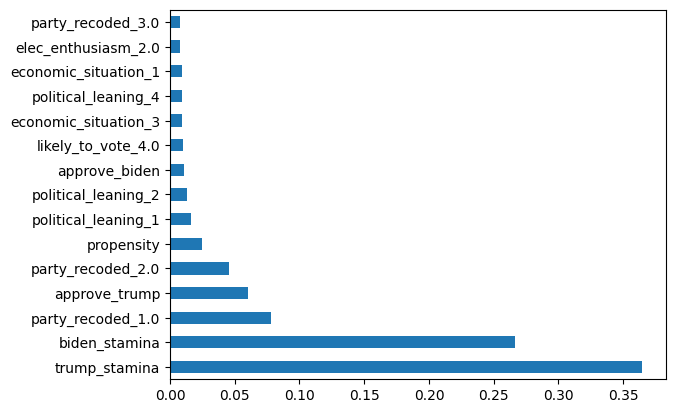

In [465]:
nat_2020_june_clean2.dropna(subset = ['STATEFIP'], how = 'all', inplace = True)
nat_2020_june_clean2 = nat_2020_june_clean2.dropna()
X = nat_2020_june_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
y = nat_2020_june_clean2['vote_choice_recoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6, random_state = 13)
june_pred_probs, june_pred,new_model_june = modelFunc(X_train, y_train, X_test, y_test, nat_2020_june, models)
features=X_train.columns
importances = new_model_june.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(new_model_june.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

Random Forest Classification
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       246
           1       0.92      0.89      0.91       189

    accuracy                           0.92       435
   macro avg       0.92      0.92      0.92       435
weighted avg       0.92      0.92      0.92       435

f1 0.9216795993763709
Gradient Boosting Classification
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       246
           1       0.91      0.90      0.90       189

    accuracy                           0.92       435
   macro avg       0.92      0.92      0.92       435
weighted avg       0.92      0.92      0.92       435

f1 0.9171888041679909
best model RandomForestClassifier(max_depth=6, max_features=0.3, min_samples_split=3,
                       n_estimators=150, random_state=13) model params {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'm

/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_48809/170343472.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred_prob = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_prob_vote'].mean()
/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_48809/170343472.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'])['predicted_vote'].value_counts().unstack(fill_value=0)


<Axes: >

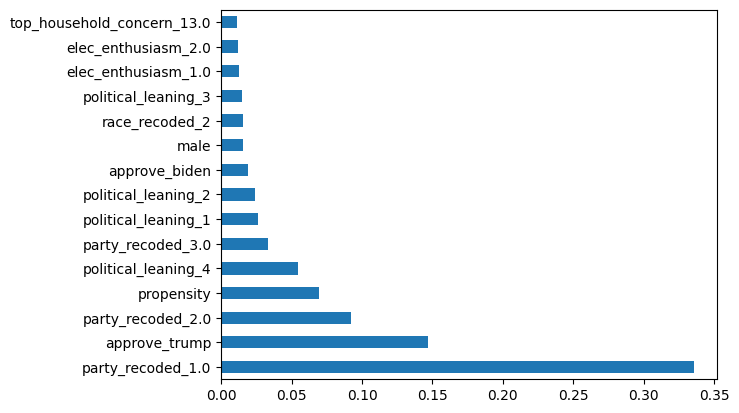

In [466]:
at_2020_aug_clean2 = nat_2020_aug_clean2.dropna()
X = nat_2020_aug_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
y = nat_2020_aug_clean2['vote_choice_recoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6, random_state = 13)
aug_pred_probs, aug_pred, new_model_aug = modelFunc(X_train, y_train, X_test, y_test, nat_2020_aug, models)
features=X_train.columns
importances = new_model_aug.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(new_model_aug.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

### Run models (if you want to run all 3 at once)

In [ ]:
## ONLY RUN THIS CELL IF YOU WANT TO RUN ALL 3 AT ONCE AND NOT MAKE PLOTS

# nat_2020_clean2 = nat_2020_clean2.dropna()
# X = nat_2020_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
# y = nat_2020_clean2['vote_choice_recoded']


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.55, random_state = 13)
# mar_pred_probs, mar_pred, new_model_mar = modelFunc(X_train, y_train, X_test, y_test, nat_2020_pre_dummies, models)
# nat_2020_june_clean2.dropna(subset = ['STATEFIP'], how = 'all', inplace = True)
# nat_2020_june_clean2 = nat_2020_june_clean2.dropna()
# X = nat_2020_june_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
# y = nat_2020_june_clean2['vote_choice_recoded']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.55, random_state = 13)
# june_pred_probs, june_pred,new_model_june = modelFunc(X_train, y_train, X_test, y_test, nat_2020_june, models)

# nat_2020_aug_clean2 = nat_2020_aug_clean2.dropna()
# X = nat_2020_aug_clean2.drop(columns = ['vote_choice_recoded', 'STATEFIP'])
# y = nat_2020_aug_clean2['vote_choice_recoded']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.55, random_state = 13)
# aug_pred_probs, aug_pred, new_model_aug = modelFunc(X_train, y_train, X_test, y_test, nat_2020_aug, models)

In [323]:
mar_pred

predicted_vote                                     0   1
age_recoded race_recoded male  education_recoded        
1           1            False 1                   1   1
                               3                   9   3
                         True  1                   3   2
                               3                  16   8
            2            False 3                   2   0
                         True  3                   2   0
            3            False 3                   2   0
                         True  3                   1   0
            4            True  1                   0   1
                               3                   4   4
            9            False 3                   1   0
2           1            False 1                   1   1
                               3                  18  24
                         True  1                   2   7
                               3                  22  19
            2            False 1                   1   0
                               3                   9   0
                         True  1                   1   0
                               3                   4   1
            3            True  3                   2   0
            4            False 3                   5   1
                         True  1                   0   1
                               3                   6   5
            9            False 3                   0   1
                         True  1                   0   1
                               3                   1   2
3           1            False 1                   7  16
                               3                  22  29
                         True  1                   2  10
                               3                  12  26
            2            False 1                   3   0
                               3                  13   0
                         True  1                   2   1
                               3                   3   0
            3            False 3                   2   0
            4            False 1                   1   0
                               3                   4   1
                         True  1                   2   0
                               3                   1   1
            9            False 1                   1   0
                               3                   0   1
                         True  3                   2   0

In [317]:
aug_pred

predicted_vote                                     0   1
age_recoded race_recoded male  education_recoded        
1           1            False 1                   0   0
                               3                   7   5
                         True  1                   2   5
                               3                   7   4
            2            False 1                   0   0
                               3                   6   0
                         True  1                   1   0
                               3                   4   0
            3            False 1                   0   0
                               3                   2   0
                         True  1                   0   0
                               3                   1   0
            4            False 1                   0   0
                               3                   4   3
                         True  1                   1   1
                               3                   2   2
            9            False 1                   0   0
                               3                   1   0
                         True  1                   0   0
                               3                   0   0
2           1            False 1                   0   0
                               3                  20  16
                         True  1                   1   7
                               3                  10  22
            2            False 1                   3   0
                               3                   7   0
                         True  1                   0   0
                               3                   4   0
            3            False 1                   0   0
                               3                   1   0
                         True  1                   0   0
                               3                   0   0
            4            False 1                   1   1
                               3                   1   1
                         True  1                   1   1
                               3                   0   3
            9            False 1                   0   0
                               3                   1   0
                         True  1                   0   0
                               3                   2   2
3           1            False 1                   3   7
                               3                  25  16
                         True  1                   5   7
                               3                  20  17
            2            False 1                   5   0
                               3                   8   0
                         True  1                   1   0
                               3                   3   0
            3            False 1                   0   0
                               3                   0   0
                         True  1                   0   0
                               3                   0   0
            4            False 1                   0   0
                               3                   4   0
                         True  1                   0   0
                               3                   1   0
            9            False 1                   0   1
                               3                   1   1
                         True  1                   0   0
                               3                   1   1

In [467]:
# do this if you want to merge the probability predicted to vote
# all_genders = [True, False ]
# all_ages = [1,2, 3]
# all_educations = [1,3]
# all_races = [1,2, 3,4,9]
# all_combinations = pd.MultiIndex.from_product([all_ages,all_races, all_genders, all_educations], names=['age_recoded','race_recoded', 'male','education_recoded']).to_frame(index=False)
# mar_pred = pd.merge(all_combinations,mar_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')
# june_pred= pd.merge(all_combinations,june_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')

# merge_mar_june = pd.merge(mar_pred, june_pred, on=['age_recoded',	'race_recoded',	'male', 'education_recoded'], how='outer')

# aug_pred = pd.merge(all_combinations,aug_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')

# do this if you want to add the two vote choice propensities together
merge_mar_june = pd.merge(mar_pred, june_pred, on=['age_recoded',	'race_recoded',	'male', 'education_recoded'], how='outer')

merge_mar_june['0_m'] = merge_mar_june['0_x'] + merge_mar_june['0_y']
# add 1_x and 1_y together
merge_mar_june['1_m'] = merge_mar_june['1_x'] + merge_mar_june['1_y']
# drop the _x and _y columns
merge_mar_june = merge_mar_june.drop(columns = ['0_x', '0_y', '1_x', '1_y']).fillna(0)

# add the propensity vibe column
# merge_mar_june['propensity_t_pred'] = merge_mar_june['1'] / (merge_mar_june['0'] + merge_mar_june['1'])

# merge_mar_june['pred_final'] = (merge_mar_june['predicted_vote_x'] + merge_mar_june['predicted_vote_y']) / 2


In [468]:
merge_mar_june

predicted_vote                                     0_m   1_m
age_recoded race_recoded male  education_recoded            
1           1            False 1                   5.0   4.0
                               3                  24.0  11.0
                         True  1                   9.0   8.0
                               3                  31.0  18.0
            2            False 1                   0.0   0.0
                               3                   5.0   0.0
                         True  1                   0.0   0.0
                               3                   7.0   0.0
            3            False 1                   0.0   0.0
                               3                   4.0   0.0
                         True  1                   0.0   0.0
                               3                   3.0   0.0
            4            False 1                   1.0   0.0
                               3                   6.0   1.0
                         True  1                   1.0   2.0
                               3                  11.0   5.0
            9            False 1                   0.0   0.0
                               3                   1.0   1.0
                         True  1                   0.0   0.0
                               3                   0.0   1.0
2           1            False 1                   8.0   8.0
                               3                  55.0  45.0
                         True  1                   7.0  15.0
                               3                  47.0  40.0
            2            False 1                   2.0   0.0
                               3                  19.0   0.0
                         True  1                   2.0   0.0
                               3                  15.0   2.0
            3            False 1                   0.0   0.0
                               3                   3.0   1.0
                         True  1                   0.0   0.0
                               3                   4.0   0.0
            4            False 1                   0.0   0.0
                               3                   9.0   2.0
                         True  1                   0.0   2.0
                               3                  11.0   7.0
            9            False 1                   0.0   0.0
                               3                   2.0   1.0
                         True  1                   0.0   1.0
                               3                   3.0   2.0
3           1            False 1                  15.0  29.0
                               3                  61.0  62.0
                         True  1                   9.0  20.0
                               3                  39.0  48.0
            2            False 1                   7.0   1.0
                               3                  26.0   1.0
                         True  1                   6.0   1.0
                               3                   5.0   0.0
            3            False 1                   0.0   0.0
                               3                   5.0   0.0
                         True  1                   0.0   0.0
                               3                   0.0   0.0
            4            False 1                   4.0   0.0
                               3                   7.0   3.0
                         True  1                   2.0   0.0
                               3                   1.0   4.0
            9            False 1                   1.0   0.0
                               3                   1.0   2.0
                         True  1                   0.0   0.0
                               3                   2.0   2.0

In [469]:
# merge_mar_june_aug = pd.merge(merge_mar_june, aug_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')

In [470]:
aug_pred.columns
# change columns to be more descriptive
aug_pred.columns = ['0_a', '1_a']

In [471]:
# aug_pred = pd.merge(all_combinations,aug_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')
merge_mar_june_aug = pd.merge(merge_mar_june, aug_pred, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')
merge_mar_june_aug['0'] = merge_mar_june_aug['0_a'] + merge_mar_june_aug['0_m']
merge_mar_june_aug['1'] = merge_mar_june_aug['1_a'] + merge_mar_june_aug['1_m']
merge_mar_june_aug = merge_mar_june_aug.drop(columns = ['0_m', '1_m', '1_a', '0_a'])
merge_mar_june_aug['pred'] = merge_mar_june_aug['1'] / (merge_mar_june_aug['0'] + merge_mar_june_aug['1'])
# merge_mar_june_aug['pred'] = (merge_mar_june_aug['pred_final'] + merge_mar_june_aug['predicted_vote']) / 2

In [472]:
merge_mar_june_aug

0     1      pred
age_recoded race_recoded male  education_recoded                      
1           1            False 1                   5.0   4.0  0.444444
                               3                  36.0  17.0  0.320755
                         True  1                  11.0  16.0  0.592593
                               3                  43.0  25.0  0.367647
            2            False 1                   0.0   0.0       NaN
                               3                  13.0   0.0  0.000000
                         True  1                   1.0   0.0  0.000000
                               3                  11.0   0.0  0.000000
            3            False 1                   0.0   0.0       NaN
                               3                   6.0   0.0  0.000000
                         True  1                   0.0   0.0       NaN
                               3                   4.0   0.0  0.000000
            4            False 1                   1.0   0.0  0.000000
                               3                  11.0   4.0  0.266667
                         True  1                   2.0   3.0  0.600000
                               3                  13.0   8.0  0.380952
            9            False 1                   0.0   0.0       NaN
                               3                   2.0   1.0  0.333333
                         True  1                   0.0   0.0       NaN
                               3                   0.0   1.0  1.000000
2           1            False 1                   8.0   9.0  0.529412
                               3                  86.0  67.0  0.437908
                         True  1                  10.0  23.0  0.696970
                               3                  66.0  71.0  0.518248
            2            False 1                   5.0   0.0  0.000000
                               3                  28.0   0.0  0.000000
                         True  1                   2.0   1.0  0.333333
                               3                  20.0   2.0  0.090909
            3            False 1                   0.0   0.0       NaN
                               3                   5.0   1.0  0.166667
                         True  1                   0.0   0.0       NaN
                               3                   4.0   0.0  0.000000
            4            False 1                   2.0   1.0  0.333333
                               3                  11.0   4.0  0.266667
                         True  1                   1.0   3.0  0.750000
                               3                  12.0  11.0  0.478261
            9            False 1                   0.0   0.0       NaN
                               3                   5.0   1.0  0.166667
                         True  1                   0.0   1.0  1.000000
                               3                   6.0   4.0  0.400000
3           1            False 1                  21.0  38.0  0.644068
                               3                  96.0  91.0  0.486631
                         True  1                  15.0  32.0  0.680851
                               3                  71.0  73.0  0.506944
            2            False 1                  13.0   1.0  0.071429
                               3                  38.0   2.0  0.050000
                         True  1                   8.0   1.0  0.111111
                               3                  11.0   0.0  0.000000
            3            False 1                   0.0   0.0       NaN
                               3                   6.0   0.0  0.000000
                         True  1                   0.0   0.0       NaN
                               3                   0.0   0.0       NaN
            4            False 1                   4.0   0.0  0.000000
                               3                  11.0   4.0  0.266667
                         True  1                   2.0   0.0  0.000000
      

In [689]:

merged_df = merge_mar_june_aug.copy()
# merged_df = merge_mar_june
post_strat = pd.read_csv("../data/post_stratification_data_by_state.csv")

propensity = pd.read_csv("../data/new_prop_scores_all.csv")



megaStrat = pd.merge(propensity, post_strat, how='left', on=['STATEFIP',	'age_recoded',	'race_recoded'	,'male'	,'education_recoded'])
# megaStrat = pd.merge(propensity, post_strat, how='left', on=[	'age_recoded',	'race_recoded'	,'male'	,'education_recoded'])
megaStrat = megaStrat.dropna()

In [690]:

propensity = pd.read_csv("../data/new_prop_scores_all.csv")

propensity['age_recoded'].value_counts()

age_recoded
1    1020
2    1020
3    1020
Name: count, dtype: int64

In [691]:
megaStrat

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,prop
0,1,1,1,1,1,0.724679,0.028241,330345.0,1.304183e-03
1,1,1,1,1,2,0.727029,0.031125,58181.0,2.296952e-04
2,1,1,1,1,4,0.659567,0.026753,381824.0,1.507419e-03
3,1,1,1,1,5,0.694327,0.035360,226141.0,8.927915e-04
4,1,1,1,1,6,0.502787,0.024290,1556291.0,6.144147e-03
...,...,...,...,...,...,...,...,...,...
3055,3,9,0,3,51,0.385860,0.040225,564.0,2.226639e-06
3056,3,9,0,3,53,0.299051,0.034299,512.0,2.021346e-06
3057,3,9,0,3,54,0.435378,0.044740,111.0,4.382216e-07
3058,3,9,0,3,55,0.383332,0.038120,258.0,1.018569e-06


In [692]:

# multiply by 0.595 if male, 0.63 if female
propensity_strat = megaStrat.copy()

propensity_strat['PERWT_scaled'] = propensity_strat.apply(
    lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
)



multipliers_age = {
    1: 0.55,
    2: 0.656,
    3: 0.73,
}
# White 69.8, black 58.7, asian 42.8, latino 38.8
# 2018 57.5, 51.4, 40.4, 40.3

multipliers = {
    1: 0.575,
    2: 0.514,
    3: 0.404,
    4: 0.403,
    9: 0.5
}

# make perwt scaled multiplied if its white black asian or latino
propensity_strat['PERWT_scaled_race'] = propensity_strat.apply(lambda row: row['PERWT'] * multipliers[row['race_recoded']], axis=1)

propensity_strat['PERWT_scaled_age'] = propensity_strat.apply(lambda row: row['PERWT'] * multipliers_age[row['age_recoded']], axis=1)

# propensity_strat['PERWT_scaled'] = propensity_strat.apply(
# propensity_strat['PERWT_scaled'] = propensity_strat.apply(
#     lambda row: row['PERWT'] * 0.698 if row['race_recoded'] == 1 elif row['PERWT'] * 0.698 if row['race_recoded'] == 1 else row['PERWT'] * 0.63, axis=1
# )
propensity_strat['trumpVote'] = propensity_strat['mrp_subgroup_estimate'] * propensity_strat['PERWT_scaled']
propensity_strat['bidenVote'] = (1 - propensity_strat['mrp_subgroup_estimate']) * propensity_strat['PERWT_scaled']
propensity_strat
print('trump percent', propensity_strat['trumpVote'].sum() / (propensity_strat['trumpVote'].sum() + propensity_strat['bidenVote'].sum()), 'trumpSum', propensity_strat['trumpVote'].sum())
print('biden percent', propensity_strat['bidenVote'].sum() / (propensity_strat['trumpVote'].sum() + propensity_strat['bidenVote'].sum()), 'bidenSum', propensity_strat['bidenVote'].sum())
propensity_strat

trump percent 0.5045714836390629 trumpSum 78339289.85778867
biden percent 0.49542851636093704 bidenSum 76919761.43221132


,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,prop,PERWT_scaled,PERWT_scaled_race,PERWT_scaled_age,trumpVote,bidenVote
0,1,1,1,1,1,0.724679,0.028241,330345.0,1.304183e-03,196555.275,189948.375,181689.75,142439.454769,54115.820231
1,1,1,1,1,2,0.727029,0.031125,58181.0,2.296952e-04,34617.695,33454.075,31999.55,25168.052867,9449.642133
2,1,1,1,1,4,0.659567,0.026753,381824.0,1.507419e-03,227185.280,219548.800,210003.20,149844.004527,77341.275473
3,1,1,1,1,5,0.694327,0.035360,226141.0,8.927915e-04,134553.895,130031.075,124377.55,93424.452883,41129.442117
4,1,1,1,1,6,0.502787,0.024290,1556291.0,6.144147e-03,925993.145,894867.325,855960.05,465577.567313,460415.577687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,3,9,0,3,51,0.385860,0.040225,564.0,2.226639e-06,355.320,282.000,411.72,137.103732,218.216268
3056,3,9,0,3,53,0.299051,0.034299,512.0,2.021346e-06,322.560,256.000,373.76,96.461991,226.098009
3057,3,9,0,3,54,0.435378,0.044740,111.0,4.382216e-07,69.930,55.500,81.03,30.446011,39.483989
3058,3,9,0,3,55,0.383332,0.038120,258.0,1.018569e-06,162.540,129.000,188.34,62.306744,100.233256


In [693]:
propensity_strat = pd.merge(propensity_strat, merged_df, on = ['age_recoded', 'education_recoded','male', 'race_recoded'], how='left')
# propensity_strat['ML_pred_mar'] = propensity_strat['predicted_vote_x']
# propensity_strat['ML_pred_june'] = propensity_strat['predicted_vote_y']
# propensity_strat['ML_pred_aug'] = propensity_strat['predicted_vote']

# propensity_strat['ML_pred_mar'] = propensity_strat['ML_pred_mar'].fillna(propensity_strat['mrp_subgroup_estimate'])
# propensity_strat['ML_pred_june'] = propensity_strat['ML_pred_june'].fillna(propensity_strat['mrp_subgroup_estimate'])
# propensity_strat['ML_pred_aug'] = propensity_strat['ML_pred_aug'].fillna(propensity_strat['mrp_subgroup_estimate'])

In [694]:
propensity_strat

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,prop,PERWT_scaled,PERWT_scaled_race,PERWT_scaled_age,trumpVote,bidenVote,0,1,pred
0,1,1,1,1,1,0.724679,0.028241,330345.0,1.304183e-03,196555.275,189948.375,181689.75,142439.454769,54115.820231,11.0,16.0,0.592593
1,1,1,1,1,2,0.727029,0.031125,58181.0,2.296952e-04,34617.695,33454.075,31999.55,25168.052867,9449.642133,11.0,16.0,0.592593
2,1,1,1,1,4,0.659567,0.026753,381824.0,1.507419e-03,227185.280,219548.800,210003.20,149844.004527,77341.275473,11.0,16.0,0.592593
3,1,1,1,1,5,0.694327,0.035360,226141.0,8.927915e-04,134553.895,130031.075,124377.55,93424.452883,41129.442117,11.0,16.0,0.592593
4,1,1,1,1,6,0.502787,0.024290,1556291.0,6.144147e-03,925993.145,894867.325,855960.05,465577.567313,460415.577687,11.0,16.0,0.592593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,3,9,0,3,51,0.385860,0.040225,564.0,2.226639e-06,355.320,282.000,411.72,137.103732,218.216268,3.0,3.0,0.500000
2991,3,9,0,3,53,0.299051,0.034299,512.0,2.021346e-06,322.560,256.000,373.76,96.461991,226.098009,3.0,3.0,0.500000
2992,3,9,0,3,54,0.435378,0.044740,111.0,4.382216e-07,69.930,55.500,81.03,30.446011,39.483989,3.0,3.0,0.500000
2993,3,9,0,3,55,0.383332,0.038120,258.0,1.018569e-06,162.540,129.000,188.34,62.306744,100.233256,3.0,3.0,0.500000


In [695]:
# propensity_strat = pd.merge(propensity_strat, merged_df, on = ['age_recoded', 'education_recoded','male', 'race_recoded'], how='left')
# # propensity_strat['ML_pred'] = propensity_strat['propensity_t_pred']
# propensity_strat['ML_pred'] = propensity_strat['pred']
# propensity_strat['ML_pred_mar'] = propensity_strat['predicted_vote_x']
# propensity_strat['ML_pred_june'] = propensity_strat['predicted_vote_y']
# propensity_strat['ML_pred_aug'] = propensity_strat['predicted_vote']


# propensity_strat['ML_pred'] = propensity_strat['ML_pred'].fillna(propensity_strat['mrp_subgroup_estimate'])
# propensity_strat['ML_pred_mar'] = propensity_strat['ML_pred_mar'].fillna(propensity_strat['mrp_subgroup_estimate'])
# propensity_strat['ML_pred_june'] = propensity_strat['ML_pred_june'].fillna(propensity_strat['mrp_subgroup_estimate'])
# propensity_strat['ML_pred_aug'] = propensity_strat['ML_pred_aug'].fillna(propensity_strat['mrp_subgroup_estimate'])


In [696]:
propensity_strat['ML_pred'] = propensity_strat['pred']
propensity_strat['ML_pred'] = propensity_strat['ML_pred'].fillna(propensity_strat['mrp_subgroup_estimate'])
# propensity_strat['ML_pred'] = (propensity_strat['ML_pred_mar']  + propensity_strat['ML_pred_june'] * 5  + propensity_strat['ML_pred_aug']) / 7

propensity_strat.loc[propensity_strat['ML_pred'] == 0, 'ML_pred'] = propensity_strat['mrp_subgroup_estimate'] / 5
propensity_strat.loc[propensity_strat['ML_pred'] == 1, 'ML_pred'] = 1 - (propensity_strat['mrp_subgroup_estimate'] / 5 )
propensity_strat

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate,mrp_subgroup_estimate_se,PERWT,prop,PERWT_scaled,PERWT_scaled_race,PERWT_scaled_age,trumpVote,bidenVote,0,1,pred,ML_pred
0,1,1,1,1,1,0.724679,0.028241,330345.0,1.304183e-03,196555.275,189948.375,181689.75,142439.454769,54115.820231,11.0,16.0,0.592593,0.592593
1,1,1,1,1,2,0.727029,0.031125,58181.0,2.296952e-04,34617.695,33454.075,31999.55,25168.052867,9449.642133,11.0,16.0,0.592593,0.592593
2,1,1,1,1,4,0.659567,0.026753,381824.0,1.507419e-03,227185.280,219548.800,210003.20,149844.004527,77341.275473,11.0,16.0,0.592593,0.592593
3,1,1,1,1,5,0.694327,0.035360,226141.0,8.927915e-04,134553.895,130031.075,124377.55,93424.452883,41129.442117,11.0,16.0,0.592593,0.592593
4,1,1,1,1,6,0.502787,0.024290,1556291.0,6.144147e-03,925993.145,894867.325,855960.05,465577.567313,460415.577687,11.0,16.0,0.592593,0.592593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,3,9,0,3,51,0.385860,0.040225,564.0,2.226639e-06,355.320,282.000,411.72,137.103732,218.216268,3.0,3.0,0.500000,0.500000
2991,3,9,0,3,53,0.299051,0.034299,512.0,2.021346e-06,322.560,256.000,373.76,96.461991,226.098009,3.0,3.0,0.500000,0.500000
2992,3,9,0,3,54,0.435378,0.044740,111.0,4.382216e-07,69.930,55.500,81.03,30.446011,39.483989,3.0,3.0,0.500000,0.500000
2993,3,9,0,3,55,0.383332,0.038120,258.0,1.018569e-06,162.540,129.000,188.34,62.306744,100.233256,3.0,3.0,0.500000,0.500000


In [697]:
propensity_strat['ML_pred'] = propensity_strat['pred'].values
propensity_strat['ML_pred'] = propensity_strat['ML_pred'].fillna(propensity_strat['mrp_subgroup_estimate'])
(propensity_strat['ML_pred'] == 0).sum()

631

In [698]:
propensity_strat['ML_pred'] = propensity_strat['pred'].values
propensity_strat['ML_pred'] = propensity_strat['ML_pred'].fillna(propensity_strat['mrp_subgroup_estimate'])
# fill with the originall propensity score if 0

# if ML pred is 0, fill with MRP pred / 5
# propensity_strat['ML_pred'] = (propensity_strat['ML_pred_mar']  + propensity_strat['ML_pred_june'] * 5  + propensity_strat['ML_pred_aug']) / 7

propensity_strat.loc[propensity_strat['ML_pred'] == 0, 'ML_pred'] = propensity_strat['mrp_subgroup_estimate'] / 10
propensity_strat.loc[propensity_strat['ML_pred'] == 1, 'ML_pred'] = 1 - (propensity_strat['mrp_subgroup_estimate'] / 4 )


# weight the mrp and ml predictions by the PERWT_scaled
# propensity_strat['mrp_and_ML'] = ((propensity_strat['mrp_subgroup_estimate'] * 5) + propensity_strat['ML_pred'] + propensity_strat['ML_pred_june']*2) / 8
propensity_strat['mrp_and_ML'] = ((propensity_strat['mrp_subgroup_estimate'] * 2) + propensity_strat['ML_pred'] *2 ) / 4
propensity_strat
propensity_strat['trumpVote_altered'] = propensity_strat['mrp_and_ML'] * propensity_strat['PERWT_scaled']
propensity_strat['bidenVote_altered'] = (1 - propensity_strat['mrp_and_ML']) * propensity_strat['PERWT_scaled']
print('trump sum', propensity_strat['trumpVote_altered'].sum(), 'biden sum', propensity_strat['bidenVote_altered'].sum())
print('trump percent', propensity_strat['trumpVote_altered'].sum() / (propensity_strat['trumpVote_altered'].sum() + propensity_strat['bidenVote_altered'].sum()))
print('biden percent', propensity_strat['bidenVote_altered'].sum() / (propensity_strat['trumpVote_altered'].sum() + propensity_strat['bidenVote_altered'].sum()))


# propensity_strat_breakdown = propensity_strat[['male', 'age_recoded','race_recoded', 'education_recoded', 'mrp_subgroup_estimate', 'ML_pred', 'mrp_and_ML', 'ML_pred_mar', 'ML_pred_june', 'ML_pred_aug', 'STATEFIP']]
propensity_strat_breakdown = propensity_strat[['male', 'age_recoded','race_recoded', 'education_recoded', 'mrp_subgroup_estimate', 'ML_pred', 'mrp_and_ML', 'STATEFIP']]


trump sum 76920153.44813848 biden sum 78338897.84186153
trump percent 0.4954310412760636
biden percent 0.5045689587239363


In [699]:
census_by_state = pd.read_csv("../data/post_stratification_data_by_state.csv")
census_by_state
elec_votes2 = pd.read_csv("../data/2020_electoral_results.csv")
elec_votes = pd.read_csv("../data/2020_ecollege_rep.csv")
elec_votes
# merge the two on stateFIP
census_by_state = pd.merge(census_by_state, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
census_by_state = pd.merge(census_by_state, elec_votes2, left_on = 'state', right_on = 'State')
# White 69.8, black 58.7, asian 42.8, latino 38.8

# multipliers = {
#     1: 0.698,
#     2: 0.587,
#     3: 0.428,
#     4: 0.388,
#     9: 1
# }

# # make perwt scaled multiplied if its white black asian or latino
# census_by_state['PERWT_scaled'] = census_by_state.apply(lambda row: row['PERWT'] * multipliers[row['race_recoded']], axis=1)
census_by_state['PERWT_scaled'] = census_by_state.apply(
    lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
)
# map the propensity strat to the census data by education, age, race, gender
census_by_state = pd.merge(census_by_state, propensity_strat_breakdown, on = ['age_recoded', 'education_recoded','male', 'race_recoded', 'STATEFIP' ])
# # census_by_state['mrp_and_ML'] = propensity_strat['mrp_and_ML']
# census_by_state
census_by_state

,STATEFIP,age_recoded,race_recoded,male,education_recoded,PERWT,prop,STATE,STATEFP,STATENS,...,State,state_votes,biden,trump,harris,pence,PERWT_scaled,mrp_subgroup_estimate,ML_pred,mrp_and_ML
0,1,1,1,False,1,327170.0,1.291648e-03,AL,1,1779775,...,alabama,9,0,9,0,9,206117.100,0.659082,0.444444,0.551763
1,1,1,1,False,3,1916.0,7.564257e-06,AL,1,1779775,...,alabama,9,0,9,0,9,1207.080,0.568722,0.320755,0.444738
2,1,1,1,True,1,330345.0,1.304183e-03,AL,1,1779775,...,alabama,9,0,9,0,9,196555.275,0.724679,0.592593,0.658636
3,1,1,1,True,3,2014.0,7.951155e-06,AL,1,1779775,...,alabama,9,0,9,0,9,1198.330,0.642281,0.367647,0.504964
4,1,1,2,False,1,171855.0,6.784736e-04,AL,1,1779775,...,alabama,9,0,9,0,9,108268.650,0.164659,0.164659,0.164659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,56,3,4,True,1,4098.0,1.617867e-05,WY,56,1779807,...,wyoming,3,0,3,0,3,2438.310,0.639364,0.063936,0.351650
2991,56,3,4,True,3,197.0,7.777446e-07,WY,56,1779807,...,wyoming,3,0,3,0,3,117.215,0.547847,0.625000,0.586424
2992,56,3,9,False,1,2080.0,8.211719e-06,WY,56,1779807,...,wyoming,3,0,3,0,3,1310.400,0.626988,0.250000,0.438494
2993,56,3,9,False,3,48.0,1.895012e-07,WY,56,1779807,...,wyoming,3,0,3,0,3,30.240,0.519113,0.500000,0.509557


In [700]:
turnout_state = pd.read_csv("../data/turnout_by_state.csv")
turnout_state['STATE_NAME'] = turnout_state['State'].str.lower()
census_by_state2 = pd.merge(census_by_state, turnout_state, on = ['STATE_NAME'])
census_by_state2['PERWT_state_scaled'] = census_by_state2['PERWT_scaled'] / 100 * census_by_state2['2020_turnout']

In [701]:

allStates = pd.read_csv("../data/new_prop_scores_all.csv")


elec_votes = pd.read_csv("../data/2020_electoral_results.csv")
elec_votes
# merge the two on stateFIP
allStates = pd.merge(allStates, census_by_state,  on = ['age_recoded', 'education_recoded','male', 'race_recoded', 'STATEFIP'])
# allStates = pd.merge(allStates, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
# census_by_state = pd.merge(census_by_state, elec_votes, left_on = 'STATEFIP', right_on = 'STATEFP')
turnout_state = pd.read_csv("../data/turnout_by_state.csv")
turnout_state['STATE_NAME'] = turnout_state['State'].str.lower()
# allStates['mrp_subgroup_estimate_x'].fillna(allStates['mrp_subgroup_estimate_y'], inplace = True)
# allStates['PERWT_scaled'] = allStates.apply(
#     lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
# )

allStates = pd.merge(allStates, turnout_state, on = ['STATE_NAME'])
allStates['PERWT_state_scaled_2016'] = allStates['PERWT'] * allStates['2016_turnout'] / 100
allStates['PERWT_state_scaled_2020'] = allStates['PERWT'] * allStates['2020_turnout'] / 100
allStates['PERWT_scaled'] = allStates.apply(
    lambda row: row['PERWT'] * 0.595 if row['male'] else row['PERWT'] * 0.63, axis=1
)

multipliers_age = {
    1: 0.55,
    2: 0.656,
    3: 0.73,
}
# White 69.8, black 58.7, asian 42.8, latino 38.8
# 2018 57.5, 51.4, 40.4, 40.3

multipliers = {
    1: 0.575,
    2: 0.514,
    3: 0.404,
    4: 0.403,
    9: 0.5
}

# make perwt scaled multiplied if its white black asian or latino
allStates['PERWT_scaled_race'] = allStates.apply(lambda row: row['PERWT'] * multipliers[row['race_recoded']], axis=1)

allStates['PERWT_scaled_age'] = allStates.apply(lambda row: row['PERWT'] * multipliers_age[row['age_recoded']], axis=1)
allStates

,age_recoded,race_recoded,male,education_recoded,STATEFIP,mrp_subgroup_estimate_x,mrp_subgroup_estimate_se,PERWT,prop,STATE,...,mrp_subgroup_estimate_y,ML_pred,mrp_and_ML,State_y,2020_turnout,2016_turnout,PERWT_state_scaled_2016,PERWT_state_scaled_2020,PERWT_scaled_race,PERWT_scaled_age
0,1,1,1,1,1,0.724679,0.028241,330345.0,1.304183e-03,AL,...,0.724679,0.592593,0.658636,Alabama,60.5,57.4,189618.030,199858.725,189948.375,181689.75
1,1,1,1,1,2,0.727029,0.031125,58181.0,2.296952e-04,AK,...,0.727029,0.592593,0.659811,Alaska,63.8,61.3,35664.953,37119.478,33454.075,31999.55
2,1,1,1,1,4,0.659567,0.026753,381824.0,1.507419e-03,AZ,...,0.659567,0.592593,0.626080,Arizona,71.9,60.4,230621.696,274531.456,219548.800,210003.20
3,1,1,1,1,5,0.694327,0.035360,226141.0,8.927915e-04,AR,...,0.694327,0.592593,0.643460,Arkansas,54.0,58.7,132744.767,122116.140,130031.075,124377.55
4,1,1,1,1,6,0.502787,0.024290,1556291.0,6.144147e-03,CA,...,0.502787,0.592593,0.547690,California,65.1,57.9,901092.489,1013145.441,894867.325,855960.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,3,9,0,3,51,0.385860,0.040225,564.0,2.226639e-06,VA,...,0.385860,0.500000,0.442930,Virginia,71.5,68.2,384.648,403.260,282.000,411.72
2991,3,9,0,3,53,0.299051,0.034299,512.0,2.021346e-06,WA,...,0.299051,0.500000,0.399526,Washington,71.5,66.3,339.456,366.080,256.000,373.76
2992,3,9,0,3,54,0.435378,0.044740,111.0,4.382216e-07,WV,...,0.435378,0.500000,0.467689,West Virginia,56.1,50.8,56.388,62.271,55.500,81.03
2993,3,9,0,3,55,0.383332,0.038120,258.0,1.018569e-06,WI,...,0.383332,0.500000,0.441666,Wisconsin,73.6,70.5,181.890,189.888,129.000,188.34


# Predict With ML

In [702]:
census_by_state

,STATEFIP,age_recoded,race_recoded,male,education_recoded,PERWT,prop,STATE,STATEFP,STATENS,...,State,state_votes,biden,trump,harris,pence,PERWT_scaled,mrp_subgroup_estimate,ML_pred,mrp_and_ML
0,1,1,1,False,1,327170.0,1.291648e-03,AL,1,1779775,...,alabama,9,0,9,0,9,206117.100,0.659082,0.444444,0.551763
1,1,1,1,False,3,1916.0,7.564257e-06,AL,1,1779775,...,alabama,9,0,9,0,9,1207.080,0.568722,0.320755,0.444738
2,1,1,1,True,1,330345.0,1.304183e-03,AL,1,1779775,...,alabama,9,0,9,0,9,196555.275,0.724679,0.592593,0.658636
3,1,1,1,True,3,2014.0,7.951155e-06,AL,1,1779775,...,alabama,9,0,9,0,9,1198.330,0.642281,0.367647,0.504964
4,1,1,2,False,1,171855.0,6.784736e-04,AL,1,1779775,...,alabama,9,0,9,0,9,108268.650,0.164659,0.164659,0.164659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,56,3,4,True,1,4098.0,1.617867e-05,WY,56,1779807,...,wyoming,3,0,3,0,3,2438.310,0.639364,0.063936,0.351650
2991,56,3,4,True,3,197.0,7.777446e-07,WY,56,1779807,...,wyoming,3,0,3,0,3,117.215,0.547847,0.625000,0.586424
2992,56,3,9,False,1,2080.0,8.211719e-06,WY,56,1779807,...,wyoming,3,0,3,0,3,1310.400,0.626988,0.250000,0.438494
2993,56,3,9,False,3,48.0,1.895012e-07,WY,56,1779807,...,wyoming,3,0,3,0,3,30.240,0.519113,0.500000,0.509557


In [708]:
# group by states and then predict if the state will go red or blue
census_by_state = allStates.copy()
# census_by_state['bothScores'] = census_by_state['mrp_subgroup_estimate_x'] 
# census_by_state['bothScores'] = ((census_by_state['mrp_subgroup_estimate_x'] * 5 ) + census_by_state['ML_pred_mar'] + census_by_state['ML_pred_june'] + census_by_state['ML_pred_aug']) / 8
census_by_state['bothScores'] = ((census_by_state['mrp_subgroup_estimate_x'] ) + census_by_state['ML_pred'] *3 ) / 4


census_by_state['trump_votes_states'] = census_by_state['bothScores'] * census_by_state['PERWT_state_scaled_2016']
census_by_state['biden_votes_states'] = (1 - census_by_state['bothScores']) * census_by_state['PERWT_state_scaled_2016']
# census_by_state['trump_votes_states'] = census_by_state['bothScores'] * census_by_state['PERWT_scaled']
# census_by_state['biden_votes_states'] = (1 - census_by_state['bothScores']) * census_by_state['PERWT_scaled']
# sum up total trump/biden votes 

census_by_state['state_demo_ratio'] =  census_by_state['trump_votes_states'] / (census_by_state['trump_votes_states'] + census_by_state['biden_votes_states'] )
# census_by_state['mrp_and_ML'].value_counts()
elec_college_pred = census_by_state.groupby('state')[['trump_votes_states','biden_votes_states'] ].sum()
# if trump votes > biden votes, then trump wins the state
elec_college_pred['state_pred'] = elec_college_pred.apply(lambda row: 1 if row['trump_votes_states'] > row['biden_votes_states'] else 0, axis = 1)
elec_college_pred
final_pred = pd.merge(elec_college_pred, elec_votes[:51], left_on = 'state', right_on = 'State')

print('trump sum', final_pred['trump_votes_states'].sum(), 'biden sum', final_pred['biden_votes_states'].sum())
final_pred['state_votes'] = final_pred['state_votes'].astype(int)
# sum up electoral votes for all states with pred of 1 and 0
final_pred.groupby('state_pred')['state_votes'].sum()

trump sum 76702242.30666815 biden sum 78545364.44233185


state_pred
0    301
1    237
Name: state_votes, dtype: int64

In [709]:
final_pred

,trump_votes_states,biden_votes_states,state_pred,State,state_votes,biden,trump,harris,pence
0,1.093170e+06,1.088233e+06,1,alabama,9,0,9,0,9
1,2.014006e+05,1.378391e+05,1,alaska,3,0,3,0,3
2,1.765079e+06,1.577669e+06,1,arizona,11,11,0,11,0
3,7.341204e+05,6.213272e+05,1,arkansas,6,0,6,0,6
4,7.436249e+06,1.016168e+07,0,california,55,55,0,55,0
5,1.652176e+06,1.424332e+06,1,colorado,9,9,0,9,0
6,8.926222e+05,9.191665e+05,0,connecticut,7,7,0,7,0
7,2.241893e+05,2.512942e+05,0,delaware,3,3,0,3,0
8,1.225285e+05,3.054938e+05,0,district of columbia,3,3,0,3,0
9,4.888277e+06,5.228350e+06,0,florida,29,0,29,0,29


In [710]:
# final_pred.to_csv("../data/final_pred_elec_ML_2020.csv")

# no ML

In [711]:
# group by states and then predict if the state will go red or blue
census_by_state = allStates.copy()
census_by_state['bothScores'] = census_by_state['mrp_subgroup_estimate_x'] 


census_by_state['trump_votes_states'] = census_by_state['bothScores'] * census_by_state['PERWT_state_scaled_2016']
census_by_state['biden_votes_states'] = (1 - census_by_state['bothScores']) * census_by_state['PERWT_state_scaled_2016']
# sum up total trump/biden votes 

census_by_state['state_demo_ratio'] =  census_by_state['trump_votes_states'] / (census_by_state['trump_votes_states'] + census_by_state['biden_votes_states'] )
# census_by_state['mrp_and_ML'].value_counts()
elec_college_pred = census_by_state.groupby('state')[['trump_votes_states','biden_votes_states'] ].sum()
# if trump votes > biden votes, then trump wins the state
elec_college_pred['state_pred'] = elec_college_pred.apply(lambda row: 1 if row['trump_votes_states'] > row['biden_votes_states'] else 0, axis = 1)
elec_college_pred
final_pred = pd.merge(elec_college_pred, elec_votes2, left_on = 'state', right_on = 'State')
# final_pred = elec_college_pred
print('trump sum', final_pred['trump_votes_states'].sum(), 'biden sum', final_pred['biden_votes_states'].sum())
final_pred['state_votes'] = final_pred['state_votes'].astype(int)
# sum up electoral votes for all states with pred of 1 and 0
final_pred.groupby('state_pred')['state_votes'].sum()

trump sum 78617130.18643793 biden sum 76630476.56256206


state_pred
0    196
1    342
Name: state_votes, dtype: int64

In [712]:
# final_pred.to_csv("../data/final_pred_elec_MRP.csv")

# 2024 preds

In [614]:
to_merge_2024 = census_by_state[['bothScores', 'age_recoded', 'education_recoded', 'male', 'STATEFIP', 'race_recoded', 'PERWT_scaled', 'PERWT']]

In [617]:
nat_2024 = pd.read_csv("../data/2024_clean_reuters_coded.csv")
nat_2024['age_recoded']  = nat_2024['age_group_coded']
nat_2024['male'] = nat_2024['gender_coded']
nat_2024['education_recoded'] = nat_2024['education_coded']
nat_2024['race_recoded'] = nat_2024['race_coded']
nat_2024['STATEFIP'] = nat_2024['STATEFP']
nat_2024['vote_choice_recoded'] = nat_2024['vote_choice_coded']
# make education 1 or 3

nat_2024['education_recoded'] = nat_2024['education_recoded'].apply(lambda x: 1 if x == 1 else 3)

# delete the old columns
nat_2024.drop(columns = ['age_group_coded', 'race_coded', 'education_coded', 'gender_coded', 'STATEFP','vote_choice_coded'], inplace = True)
nat_2024

,region_coded,party_id_coded,religion_coded,age_recoded,male,education_recoded,race_recoded,STATEFIP,vote_choice_recoded
0,2.0,1.0,3,2.0,0.0,1,1.0,17,1.0
1,3.0,0.0,0,3.0,1.0,3,1.0,12,0.0
2,2.0,1.0,1,3.0,1.0,3,1.0,55,1.0
3,3.0,1.0,0,3.0,0.0,1,1.0,12,1.0
4,3.0,3.0,0,3.0,1.0,1,1.0,13,1.0
...,...,...,...,...,...,...,...,...,...
3023,3.0,1.0,3,2.0,1.0,1,1.0,40,1.0
3024,3.0,1.0,-9,3.0,1.0,1,2.0,47,1.0
3025,3.0,2.0,-9,3.0,1.0,3,1.0,22,0.0
3026,3.0,0.0,-9,2.0,1.0,3,9.0,51,0.0


In [618]:
nat_2024_to_pred = pd.merge(nat_2024, to_merge_2024, on = ['age_recoded', 'education_recoded', 'race_recoded', 'male', 'STATEFIP'])

In [619]:
new_mrp_2024 = pd.read_csv("../data/prop_scores_2024.csv")
new_mrp_2024.dropna(inplace = True)
nat_2024_to_pred = pd.merge(nat_2024_to_pred, new_mrp_2024, on = ['age_recoded', 'education_recoded', 'race_recoded', 'male', 'STATEFIP'])

In [620]:
nat_2024_to_pred.columns

Index(['region_coded', 'party_id_coded', 'religion_coded', 'age_recoded',
       'male', 'education_recoded', 'race_recoded', 'STATEFIP',
       'vote_choice_recoded', 'bothScores', 'PERWT_scaled', 'PERWT',
       'mrp_subgroup_estimate', 'mrp_subgroup_estimate_se'],
      dtype='object')

In [621]:
# nat_2024_to_pred.to_csv("../data/nat_2024_to_pred.csv", index = False)

In [622]:
categoricals_2024 = ['education_recoded', 'race_recoded', 'region_coded', 'age_recoded', 'party_id_coded']

In [623]:
nat_2024_to_pred.drop(columns = ['PERWT_scaled', 'PERWT', 'mrp_subgroup_estimate_se', 'bothScores'], inplace = True)

In [624]:
nat_2024_to_pred

,region_coded,party_id_coded,religion_coded,age_recoded,male,education_recoded,race_recoded,STATEFIP,vote_choice_recoded,mrp_subgroup_estimate
0,2.0,1.0,3,2.0,0.0,1,1.0,17,1.0,0.532649
1,3.0,0.0,0,3.0,1.0,3,1.0,12,0.0,0.627119
2,2.0,1.0,1,3.0,1.0,3,1.0,55,1.0,0.617737
3,3.0,1.0,0,3.0,0.0,1,1.0,12,1.0,0.637105
4,3.0,3.0,0,3.0,1.0,1,1.0,13,1.0,0.709389
...,...,...,...,...,...,...,...,...,...,...
3022,3.0,1.0,3,2.0,1.0,1,1.0,40,1.0,0.742905
3023,3.0,1.0,-9,3.0,1.0,1,2.0,47,1.0,0.235091
3024,3.0,2.0,-9,3.0,1.0,3,1.0,22,0.0,0.652693
3025,3.0,0.0,-9,2.0,1.0,3,9.0,51,0.0,0.466892


In [625]:
dummies_2024 = dummyGrabber(nat_2024_to_pred, categoricals_2024)
dummies_2024
nat_2024_clean = dummies_2024.drop(columns = [ 'religion_coded'])
nat_2024_clean.columns


Index(['male', 'STATEFIP', 'vote_choice_recoded', 'mrp_subgroup_estimate',
       'education_recoded_1', 'education_recoded_3', 'race_recoded_1.0',
       'race_recoded_2.0', 'race_recoded_4.0', 'race_recoded_9.0',
       'region_coded_1.0', 'region_coded_2.0', 'region_coded_3.0',
       'region_coded_4.0', 'age_recoded_1.0', 'age_recoded_2.0',
       'age_recoded_3.0', 'party_id_coded_0.0', 'party_id_coded_1.0',
       'party_id_coded_2.0', 'party_id_coded_3.0', 'party_id_coded_4.0'],
      dtype='object')

In [626]:
nat_2024_clean.dropna(subset = ['STATEFIP'], how = 'all', inplace = True)
nat_2024_clean = nat_2024_clean.dropna()
X = nat_2024_clean.drop(columns = ['vote_choice_recoded', ])
y = nat_2024_clean['vote_choice_recoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 11)
# preds_2024 = modelFunc(X_train, y_train, X_test, y_test, nat_2024_to_pred, models)

In [627]:
nat_2024_clean.columns

Index(['male', 'STATEFIP', 'vote_choice_recoded', 'mrp_subgroup_estimate',
       'education_recoded_1', 'education_recoded_3', 'race_recoded_1.0',
       'race_recoded_2.0', 'race_recoded_4.0', 'race_recoded_9.0',
       'region_coded_1.0', 'region_coded_2.0', 'region_coded_3.0',
       'region_coded_4.0', 'age_recoded_1.0', 'age_recoded_2.0',
       'age_recoded_3.0', 'party_id_coded_0.0', 'party_id_coded_1.0',
       'party_id_coded_2.0', 'party_id_coded_3.0', 'party_id_coded_4.0'],
      dtype='object')

## Train the 2024 model on the cleaned data

In [628]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
models2 = [

    ("Random Forest Classification", RandomForestClassifier(),{'n_estimators': [150,200, 250, 350, 400], 'max_depth':[ 3, 4, 5, 6], 'min_samples_split': [3, 4, 5, 6],'max_features': ['sqrt', 'log2', 0.6], 'random_state': [13]}),

    ('Gradient Boosting Classification', GradientBoostingClassifier(), {'n_estimators': [100, 150,200, 300, 450], 'max_depth': [3, 5, 4, 6,7], 'learning_rate': [0.01, 0.025, .05, 0.75, 0.1], 'max_features': ['sqrt', 'log2', 0.5], 'random_state': [13]}),
   
]

In [630]:
best_f1 = 0
for model in models2:

    name = model[0]
    print(model[0])
    clf = model[1]
    params = model[2]

    
    grids =  GridSearchCV(clf, param_grid=params, scoring=['f1_weighted', 'neg_root_mean_squared_error'],cv=3, n_jobs=-1, refit='f1_weighted')
    grids.fit(X_train, y_train)
    y_preds = grids.best_estimator_.predict(X_test)
    if f1_score(y_test, y_preds, average='weighted') >= best_f1:
        new_model_2024 = grids.best_estimator_
        best_f1 = f1_score(y_test, y_preds, average='weighted')



    print('f1', f1_score(y_test, y_preds, average='weighted'))
print('best model', new_model_2024, 'model params', new_model_2024.get_params())
new_model_2024.fit(X_train, y_train)

y_preds = new_model_2024.predict(X_test)
y_preds_prob = new_model_2024.predict_proba(X_test)
y_preds_prob = [x[1] for x in y_preds_prob]
X_test_copy = X_test.copy()
X_test_copy['predicted_prob_vote'] = y_preds_prob
X_test_copy['predicted_vote'] = y_preds
X_test_copy['actual_vote'] = y_test
X_test_copy_filtered = X_test_copy[['male', 'STATEFIP', 'mrp_subgroup_estimate',
       'education_recoded_1', 'education_recoded_3', 'race_recoded_1.0',
       'race_recoded_2.0', 'race_recoded_4.0', 'race_recoded_9.0',
       'region_coded_1.0', 'region_coded_2.0', 'region_coded_3.0',
       'region_coded_4.0', 'age_recoded_1.0', 'age_recoded_2.0',
       'age_recoded_3.0', 'party_id_coded_0.0', 'party_id_coded_1.0',
       'party_id_coded_2.0', 'party_id_coded_3.0', 'party_id_coded_4.0']]

filtered_nat_df = nat_2024_to_pred.loc[X_test_copy_filtered.index]

filtered_nat_df['actual_vote'] = X_test_copy['actual_vote']
filtered_nat_df['predicted_prob_vote'] = X_test_copy['predicted_prob_vote']
filtered_nat_df['predicted_vote'] = X_test_copy['predicted_vote']

df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'], )['predicted_vote'].value_counts().unstack(fill_value=0)

# probability version
df_final_pred2 = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_prob_vote'].mean()



Random Forest Classification
f1 0.8707460881650854
Gradient Boosting Classification
f1 0.8745150098135592
best model GradientBoostingClassifier(learning_rate=0.01, max_depth=4, max_features='sqrt',
                           n_estimators=150, random_state=13) model params {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_iter_no_change': None, 'random_state': 13, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_48809/3075216966.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'], )['predicted_vote'].value_counts().unstack(fill_value=0)
/var/folders/k9/6c26p32970l0vhs0_8nyb60h0000gn/T/ipykernel_48809/3075216966.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_final_pred2 = filtered_nat_df.groupby(['age_recoded','race_recoded', 'male','education_recoded'] )['predicted_prob_vote'].mean()


<Axes: >

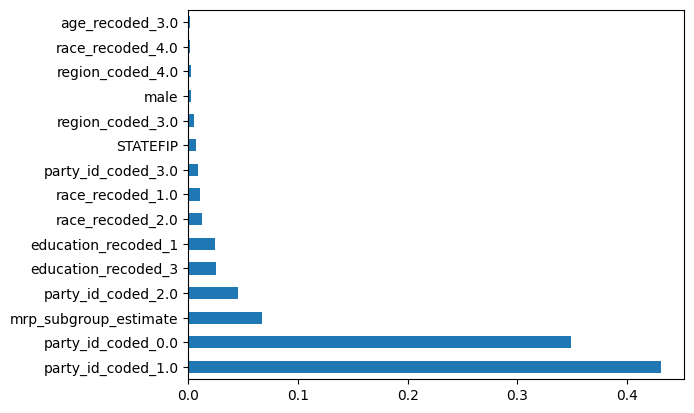

In [631]:
features=X_train.columns
importances = new_model_2024.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(new_model_2024.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')


In [633]:
df_final_pred['ml_preds'] = df_final_pred[1] / (df_final_pred[0] + df_final_pred[1])
df_final_pred

predicted_vote                                   0.0  1.0  ml_preds
age_recoded race_recoded male education_recoded                    
1.0         1.0          0.0  1                    8   21  0.724138
                              3                   14    6  0.300000
                         1.0  1                    7   26  0.787879
                              3                   25   11  0.305556
            2.0          0.0  1                    7    0  0.000000
                              3                    2    0  0.000000
                         1.0  1                    7    0  0.000000
                              3                    3    1  0.250000
            4.0          0.0  1                    3    2  0.400000
                              3                    4    0  0.000000
                         1.0  1                    5    3  0.375000
                              3                    2    1  0.333333
            9.0          0.0  1                    3    2  0.400000
                              3                    4    2  0.333333
                         1.0  1                    2    6  0.750000
                              3                    1    1  0.500000
2.0         1.0          0.0  1                    5   30  0.857143
                              3                   32   18  0.360000
                         1.0  1                   12   46  0.793103
                              3                   38   26  0.406250
            2.0          0.0  1                    8    2  0.200000
                              3                    7    1  0.125000
                         1.0  1                    8    2  0.200000
                              3                    7    0  0.000000
            4.0          0.0  1                    4    6  0.600000
                              3                    6    0  0.000000
                         1.0  1                    8   14  0.636364
                              3                    6    2  0.250000
            9.0          0.0  1                    2    3  0.600000
                              3                   12    1  0.076923
                         1.0  1                    1    1  0.500000
                              3                   13    1  0.071429
3.0         1.0          0.0  1                   39  101  0.721429
                              3                   65   21  0.244186
                         1.0  1                   19   84  0.815534
                              3                   75   44  0.369748
            2.0          0.0  1                   13    0  0.000000
                              3                   10    1  0.090909
                         1.0  1                    7    2  0.222222
                              3                    8    0  0.000000
            4.0          0.0  1                    7    8  0.533333
                              3                    3    1  0.250000
                         1.0  1                    4   10  0.714286
                              3                    5    3  0.375000
            9.0          0.0  1                    6    1  0.142857
                              3                    9    2  0.181818
                         1.0  1                    3    4  0.571429
                              3                    3    1  0.250000

In [662]:
all_genders = [True, False ]
all_ages = [1,2, 3]
all_educations = [1,3]
all_races = [1,2, 3,4,9]
all_combinations = pd.MultiIndex.from_product([all_ages,all_races, all_genders, all_educations], names=['age_recoded','race_recoded', 'male','education_recoded']).to_frame(index=False)
preds_2024_probs = pd.merge(all_combinations,df_final_pred2, on=['age_recoded','race_recoded', 'male','education_recoded'], how='outer')
df_final_pred['predicted_vote'] = df_final_pred[1] / (df_final_pred[0] + df_final_pred[1])
preds_2024 = df_final_pred

In [663]:
preds_2024_probs

,age_recoded,race_recoded,male,education_recoded,predicted_prob_vote
0,1,1,False,1,0.616822
1,1,1,False,3,0.366198
2,1,1,True,1,0.617990
3,1,1,True,3,0.399791
4,1,2,False,1,0.199588
5,1,2,False,3,0.161452
6,1,2,True,1,0.261247
7,1,2,True,3,0.380851
8,1,3,False,1,NaN
9,1,3,False,3,NaN


## Prepare the 2024 MRP to be combined with the predictions and get results

In [673]:
new_mrp_2024 = pd.read_csv("../data/prop_scores_2024.csv")
new_mrp_2024.dropna(inplace = True)

In [674]:
new_mrp_2024['prop_pred'] = new_mrp_2024['mrp_subgroup_estimate']
new_mrp_2024.drop(columns = ['mrp_subgroup_estimate'], inplace = True)

In [675]:
new_census_by_state = pd.merge(census_by_state, new_mrp_2024, on = ['age_recoded', 'education_recoded', 'male', 'race_recoded', 'STATEFIP'], how='left')


In [676]:
# group by states and then predict if the state will go red or blue
# census_by_state_2024 = allStates.copy()
census_by_state_2024 = pd.merge(new_census_by_state, preds_2024, on = ['age_recoded', 'education_recoded', 'male', 'race_recoded'], how='left')
census_by_state_2024['predicted_vote'] = census_by_state_2024['predicted_vote'].fillna(census_by_state_2024['prop_pred'])
census_by_state_2024.loc[census_by_state_2024['predicted_vote'] == 0, 'predicted_vote'] = census_by_state_2024['prop_pred'] / 10
census_by_state_2024.loc[census_by_state_2024['predicted_vote'] == 1, 'predicted_vote'] = 1 - (census_by_state_2024['prop_pred'] / 4 )

# use ML and MRP

# census_by_state_2024['bothScores_2024'] = ((census_by_state_2024['prop_pred'] *10 ) + census_by_state_2024['predicted_vote']) / 11 

# only use the mrp propensities
census_by_state_2024['bothScores_2024'] = ((census_by_state_2024['prop_pred']))

census_by_state_2024['trump_votes_states'] = census_by_state_2024['bothScores_2024'] * census_by_state_2024['PERWT_state_scaled_2020']
census_by_state_2024['biden_votes_states'] = (1 - census_by_state_2024['bothScores_2024']) * census_by_state_2024['PERWT_state_scaled_2020']


# sum up total trump/biden votes 

census_by_state_2024['state_demo_ratio'] =  census_by_state_2024['trump_votes_states'] / (census_by_state_2024['trump_votes_states'] + census_by_state_2024['biden_votes_states'] )
# census_by_state['mrp_and_ML'].value_counts()
elec_college_pred_2024 = census_by_state_2024.groupby('state')[['trump_votes_states','biden_votes_states'] ].sum()
# if trump votes > biden votes, then trump wins the state
elec_college_pred_2024['state_pred'] = elec_college_pred_2024.apply(lambda row: 1 if row['trump_votes_states'] > row['biden_votes_states'] else 0, axis = 1)
elec_college_pred_2024
final_pred_2024 = pd.merge(elec_college_pred_2024, elec_votes[:51], left_on = 'state', right_on = 'state')

print('trump sum', final_pred_2024['trump_votes_states'].sum(), 'biden sum', final_pred_2024['biden_votes_states'].sum())
final_pred_2024['state_votes'] = final_pred_2024['e_votes'].astype(int)
# sum up electoral votes for all states with pred of 1 and 0
final_pred_2024.groupby('state_pred')['state_votes'].sum()

trump sum 84859016.7687518 biden sum 84196992.3372482


state_pred
0    199
1    339
Name: state_votes, dtype: int64

In [683]:
# group by states and then predict if the state will go red or blue
# census_by_state_2024 = allStates.copy()
census_by_state_2024 = pd.merge(new_census_by_state, preds_2024, on = ['age_recoded', 'education_recoded', 'male', 'race_recoded'], how='left')
census_by_state_2024 = pd.merge(census_by_state_2024, preds_2024_probs, on = ['age_recoded', 'education_recoded', 'male', 'race_recoded'], how='left')
census_by_state_2024['predicted_vote'] = census_by_state_2024['predicted_vote'].fillna(census_by_state_2024['prop_pred'])
census_by_state_2024['predicted_prob_vote'] = census_by_state_2024['predicted_prob_vote'].fillna(census_by_state_2024['prop_pred'])
census_by_state_2024.loc[census_by_state_2024['predicted_vote'] == 0, 'predicted_vote'] = census_by_state_2024['prop_pred'] / 10
census_by_state_2024.loc[census_by_state_2024['predicted_vote'] == 1, 'predicted_vote'] = 1 - (census_by_state_2024['prop_pred'] / 4 )

# use ML and MRP

# census_by_state_2024['bothScores_2024'] = ((census_by_state_2024['prop_pred'] *10 ) + census_by_state_2024['predicted_vote']) / 11 

# use ML (probabilities) and MRP

# census_by_state_2024['bothScores_2024'] = ((census_by_state_2024['prop_pred'] *3 ) + census_by_state_2024['predicted_prob_vote']) / 4

# only use the mrp propensities
census_by_state_2024['bothScores_2024'] = ((census_by_state_2024['prop_pred']))

census_by_state_2024['trump_votes_states'] = census_by_state_2024['bothScores_2024'] * census_by_state_2024['PERWT_state_scaled_2020']
census_by_state_2024['biden_votes_states'] = (1 - census_by_state_2024['bothScores_2024']) * census_by_state_2024['PERWT_state_scaled_2020']

# census_by_state_2024['trump_votes_states'] = census_by_state_2024['bothScores_2024'] * census_by_state_2024['PERWT']
# census_by_state_2024['biden_votes_states'] = (1 - census_by_state_2024['bothScores_2024']) * census_by_state_2024['PERWT']


# sum up total trump/biden votes 

census_by_state_2024['state_demo_ratio'] =  census_by_state_2024['trump_votes_states'] / (census_by_state_2024['trump_votes_states'] + census_by_state_2024['biden_votes_states'] )
# census_by_state['mrp_and_ML'].value_counts()
elec_college_pred_2024 = census_by_state_2024.groupby('state')[['trump_votes_states','biden_votes_states'] ].sum()
# if trump votes > biden votes, then trump wins the state
elec_college_pred_2024['state_pred'] = elec_college_pred_2024.apply(lambda row: 1 if row['trump_votes_states'] > row['biden_votes_states'] else 0, axis = 1)
elec_college_pred_2024
final_pred_2024 = pd.merge(elec_college_pred_2024, elec_votes[:51], left_on = 'state', right_on = 'state')

print('trump sum', final_pred_2024['trump_votes_states'].sum(), 'biden sum', final_pred_2024['biden_votes_states'].sum())
final_pred_2024['state_votes'] = final_pred_2024['e_votes'].astype(int)
# sum up electoral votes for all states with pred of 1 and 0
final_pred_2024.groupby('state_pred')['state_votes'].sum()

trump sum 127286351.77271216 biden sum 126010179.22728784


state_pred
0    199
1    339
Name: state_votes, dtype: int64

In [684]:
final_pred_2024

,state,trump_votes_states,biden_votes_states,state_pred,STATE,STATEFP,STATENS,STATE_NAME,e_votes,state_votes
0,alabama,2.167536e+06,1.632818e+06,1,AL,1,1779775,alabama,9.0,9
1,alaska,3.641010e+05,1.893080e+05,1,AK,2,1785533,alaska,3.0,3
2,arizona,3.237974e+06,2.296378e+06,1,AZ,4,1779777,arizona,11.0,11
3,arkansas,1.374765e+06,9.343446e+05,1,AR,5,68085,arkansas,6.0,6
4,california,1.154338e+07,1.885028e+07,0,CA,6,1779778,california,54.0,54
5,colorado,2.467308e+06,1.959322e+06,1,CO,8,1779779,colorado,10.0,10
6,connecticut,1.264123e+06,1.571227e+06,0,CT,9,1779780,connecticut,7.0,7
7,delaware,3.519441e+05,4.112719e+05,0,DE,10,1779781,delaware,3.0,3
8,district of columbia,1.016654e+05,4.744076e+05,0,DC,11,1702382,district of columbia,3.0,3
9,florida,8.957273e+06,8.045461e+06,1,FL,12,294478,florida,30.0,30


In [685]:
# final_pred_2024.to_csv("../data/final_pred_elec_2024.csv")